## Importing Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segysak
import os
import sys
import pandas as pd
from os.path import join, isdir, expanduser
from os import listdir
from torch import from_numpy, Tensor
from seispro import agc
from segysak.segy import segy_loader,segy_header_scan, segy_header_scrape
from warnings import filterwarnings
from Utils import shift_function, gain_functions, plotting_functions
# from plotting_functions import plot_single_trace_fig,wigle_plot
# from pyts.decomposition import SingularSpectrumAnalysis
# from sklearn.preprocessing import minmax_scale

## Filtering Warnings

In [2]:
filterwarnings('ignore')

## Loading Data

In [3]:
directory = 'D:/Dados_TCC/Dados_treino'   #'/mnt/camobi_1/romulo_files/pytorch_unet/CNN_FP/Dados'
files = listdir(directory)
for i in range(len(files)):
    if isdir(join(directory,files[i])):
        print(f'Index:{i}, Directory: {files[i]}')
    else:
        print(f'Index:{i}, File: {files[i]}')

Index:0, File: CREWS_Completo_OFF-0-1500_semAGC.sgy
Index:1, File: Crews_data_label.p
Index:2, File: CREWS_FFID_19-27_OFFSET.sgy
Index:3, File: CREWS_FFID_19-27_OFFSET_0-1500.sgy
Index:4, File: dataset_train.csv
Index:5, File: dataset_train.npz
Index:6, File: fp_crews_dict.p
Index:7, File: REC_FFID_111-120_OFFSET.sgy


In [4]:
#Choose the index
index = 0

#Loading the data
data =  segy_loader(join(directory,files[index])) #Carregamento da sísmica
header = segy_header_scrape(join(directory,files[index])) #carregamento do header

  0%|          | 0.00/102k [00:00<?, ? traces/s]

                        byte_loc     count          mean            std   
TRACE_SEQUENCE_LINE            1  101686.0  1.273288e+05   67154.081504  \
TRACE_SEQUENCE_FILE            5  101686.0  5.084350e+04   29354.364074   
FieldRecord                    9  101686.0  2.087644e+02     101.523798   
TraceNumber                   13  101686.0  2.304566e+02     143.872023   
EnergySourcePoint             17  101686.0  2.087644e+02     101.523798   
CDP                           21  101686.0  8.484119e+03    2215.891245   
offset                        37  101686.0  9.302584e+02     367.856397   
ReceiverGroupElevation        41  101686.0  9.284416e+06  121699.102995   
SourceSurfaceElevation        45  101686.0  9.284153e+06  106633.007086   
SourceX                       73  101686.0  3.474945e+07   67248.256152   
SourceY                       77  101686.0  5.647046e+08   61412.417462   
GroupX                        81  101686.0  3.475618e+07   68088.978389   
GroupY                   

Converting SEGY:   0%|          | 0.00/102k [00:00<?, ? traces/s]

  0%|          | 0.00/102k [00:00<?, ? traces/s]

In [5]:
# Showing header columns
# header.columns

## Processing Data

In [6]:
#Obtendo os números dos traços de cada shot gather
shoot_number = header.FieldRecord.unique()
# print(f'Número do tiro: {shoot_number}')
shoot_index = [(header[header.FieldRecord == i]['TRACE_SEQUENCE_FILE'].min()-1,
header[header.FieldRecord == i]['TRACE_SEQUENCE_FILE'].max()-1) for i in header.FieldRecord.unique()]
# print('')
# print(f'Index do tiro: {shoot_index}')

In [7]:
## Resumindo
#As amostras do tiro vão da linha tal até linha tal
for i in range(len(shoot_number)):
    print(f'Número do tiro: {shoot_number[i]}, Index: {shoot_index[i][0]} até {shoot_index[i][1]}')
    print('')

Número do tiro: 18, Index: 0 até 358

Número do tiro: 19, Index: 359 até 488

Número do tiro: 20, Index: 489 até 633

Número do tiro: 21, Index: 634 até 784

Número do tiro: 22, Index: 785 até 939

Número do tiro: 23, Index: 940 até 1105

Número do tiro: 24, Index: 1106 até 1261

Número do tiro: 25, Index: 1262 até 1437

Número do tiro: 26, Index: 1438 até 1628

Número do tiro: 27, Index: 1629 até 1828

Número do tiro: 28, Index: 1829 até 1969

Número do tiro: 29, Index: 1970 até 2168

Número do tiro: 30, Index: 2169 até 2317

Número do tiro: 32, Index: 2318 até 2473

Número do tiro: 33, Index: 2474 até 2672

Número do tiro: 34, Index: 2673 até 2832

Número do tiro: 35, Index: 2833 até 3047

Número do tiro: 36, Index: 3048 até 3211

Número do tiro: 37, Index: 3212 até 3453

Número do tiro: 38, Index: 3454 até 3685

Número do tiro: 39, Index: 3686 até 3849

Número do tiro: 40, Index: 3850 até 4067

Número do tiro: 41, Index: 4068 até 4246

Número do tiro: 42, Index: 4247 até 4430

Númer

In [8]:
#pegando todos os valores das amostras e transformando em DataFrame
X = pd.DataFrame(data.data.values)

#Criando uma coluna nula n_tiro preenchida por zeros
X['N_tiro'] = 0

#Substituindo os valores da coluna n_tiro pelo numero do tiro respectivo, baseado pelo index
for i,j in zip(shoot_number,shoot_index):
    X['N_tiro'].loc[j[0]:j[1]+1] = i

X

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,1000,N_tiro
0,-4.768662e-07,-5.960828e-07,1.192166e-07,5.960828e-07,-1.192166e-07,-7.152993e-07,-1.192166e-07,5.960828e-07,4.768662e-07,-2.384331e-07,...,2.095868e-08,5.029126e-08,-8.708855e-08,-2.696396e-07,-6.005286e-08,-5.988536e-07,-5.522947e-07,8.847627e-08,-4.261002e-07,18
1,2.375194e-07,-1.187597e-07,2.375194e-07,4.750387e-07,0.000000e+00,2.375194e-07,1.187597e-07,2.375194e-07,3.562791e-07,-2.375194e-07,...,-2.793960e-07,-4.940434e-07,2.421344e-07,-3.255137e-07,-5.401612e-07,-6.146843e-08,-9.781155e-08,-1.941798e-07,-2.863816e-07,18
2,4.768662e-07,1.430599e-06,4.768662e-07,1.192166e-07,2.503548e-06,4.291796e-06,4.291796e-06,4.768663e-06,6.318477e-06,8.464375e-06,...,7.289812e-06,2.720513e-06,2.068888e-07,3.073508e-06,7.229784e-06,8.485464e-06,4.380154e-06,1.544116e-07,-1.021940e-08,18
3,8.372444e-08,8.372444e-08,8.372444e-08,0.000000e+00,-8.372444e-08,0.000000e+00,0.000000e+00,-8.372444e-08,-8.372444e-08,-8.372444e-08,...,3.939321e-07,3.492270e-07,2.980033e-07,2.300441e-07,2.649483e-07,1.932444e-07,1.173336e-07,1.588025e-07,6.425353e-08,18
4,-2.102857e-07,2.102857e-07,-1.051429e-07,-3.154286e-07,-2.102857e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.102857e-07,...,-1.950958e-07,-7.452763e-08,4.018773e-07,1.075786e-07,-9.639439e-08,1.573807e-07,2.067313e-07,2.873275e-07,2.160618e-07,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101681,-7.554508e-09,-2.313376e-08,-1.510902e-08,3.304303e-09,1.180290e-08,4.720434e-09,6.138379e-09,2.077354e-08,2.502374e-08,1.180290e-08,...,1.789340e-07,2.100965e-07,2.540019e-07,2.653422e-07,2.752532e-07,2.842160e-07,2.440908e-07,1.784665e-07,8.687812e-08,375
101682,-1.414573e-08,2.074961e-08,1.461829e-08,1.226027e-08,3.112204e-08,1.084499e-08,-4.243482e-09,-1.415286e-09,-3.300751e-09,-7.074057e-09,...,4.805120e-07,5.064568e-07,4.956100e-07,4.649450e-07,4.743852e-07,4.800431e-07,4.753230e-07,4.904210e-07,4.941995e-07,375
101683,-9.856265e-09,-4.224113e-09,-2.205837e-08,9.391359e-10,1.361014e-08,-9.391359e-10,1.548842e-08,1.408038e-09,-1.689645e-08,1.595732e-08,...,1.145239e-07,1.140486e-07,8.213232e-08,4.927938e-08,3.894819e-08,3.755019e-08,8.917823e-08,1.051293e-07,1.253121e-07,375
101684,-5.144387e-08,-1.076054e-07,4.153370e-08,1.368612e-07,2.643108e-08,-5.568685e-08,4.717716e-09,5.474331e-08,-5.192454e-09,-4.483314e-08,...,-1.552631e-07,-4.422143e-07,-5.951137e-07,-4.016206e-07,-1.713156e-07,-1.297765e-07,-3.066622e-08,2.656985e-07,4.025680e-07,375


In [8]:
dados = np.asarray(X[np.arange(0,1001)])
dados.shape

(101686, 1001)

In [19]:
dados[101685]

array([ 2.7800081e-07, -2.6427600e-08, -1.6331092e-07, ...,
        4.4376328e-08, -1.8879518e-08,  1.8879183e-07], dtype=float32)

### Loading Picks

In [9]:
#Carregando picks do Crews
#Picks são o registro da primeira quebra no dado sísmico
index = 6
picks = pd.read_pickle(join(directory,files[index]))
#Mostrando as chaves
picks.keys()

dict_keys(['n_trace_18', 'n_ams_fp_18', 'alig_18', 'n_trace_39', 'n_ams_fp_39', 'alig_39', 'n_trace_59', 'n_ams_fp_59', 'alig_59', 'n_trace_80', 'n_ams_fp_80', 'alig_80', 'n_trace_100', 'n_ams_fp_100', 'alig_100', 'n_trace_120', 'n_ams_fp_120', 'alig_120', 'n_trace_140', 'n_ams_fp_140', 'alig_140', 'n_trace_161', 'n_ams_fp_161', 'alig_161', 'n_trace_183', 'n_ams_fp_183', 'alig_183', 'n_trace_203', 'n_ams_fp_203', 'alig_203', 'n_trace_223', 'n_ams_fp_223', 'alig_223', 'n_trace_243', 'n_ams_fp_243', 'n_trace_268', 'n_ams_fp_268', 'alig_268', 'n_trace_288', 'n_ams_fp_288', 'alig_288', 'n_trace_309', 'n_ams_fp_309', 'alig_309', 'n_trace_329', 'n_ams_fp_329', 'alig_329', 'n_trace_351', 'n_ams_fp_351', 'alig_351', 'n_trace_371', 'n_ams_fp_371', 'alig_371', 'aligment_39', 'aligment_w_smooth_39', 'aligment_mean_39', 'aligment_18', 'aligment_w_smooth_18', 'aligment_mean_18', 'aligment_59', 'aligment_w_smooth_59', 'aligment_mean_59', 'aligment_80', 'aligment_w_smooth_80', 'aligment_mean_80', 'al

In [10]:
picks['alig_268']

array([ 29,  37,  39,  48,  50,  58,  60,  55,  56,  62,  67,  65,  71,
        75,  75,  74,  87,  82,  82,  88,  87,  89,  90,  95,  89,  93,
        95,  99, 101,  97, 100, 106, 103, 101, 107, 111, 111, 109, 110,
       110, 110, 114, 112, 112, 114, 115, 115, 115, 117, 119, 123, 123,
       120, 121, 118, 125, 126, 127, 130, 130, 132, 131, 132, 133, 138,
       140, 130, 140, 132, 133, 137, 138, 134, 137, 140, 142, 139, 148,
       143, 144, 146, 144, 146, 147, 151, 151, 156, 150, 152, 152, 152,
       146, 152, 154, 155, 156, 158, 158, 159, 158, 159, 157, 163, 161,
       160, 161, 162, 163, 164, 169, 168, 169, 168, 169, 172, 170, 175,
       172, 179, 171, 178, 178, 176, 174, 176, 178, 181, 175, 174, 177,
       177, 177, 181, 183, 179, 182, 185, 183, 182, 190, 187, 189, 186,
       189, 191, 195, 194, 193, 196, 189, 195, 196, 193, 196, 195, 201,
       199, 196, 199, 198, 199, 200, 199, 201, 201, 202, 202, 204, 201,
       198, 205, 203, 209, 205, 208, 209, 210, 209, 206, 208, 20

(0.0, 1500.0)

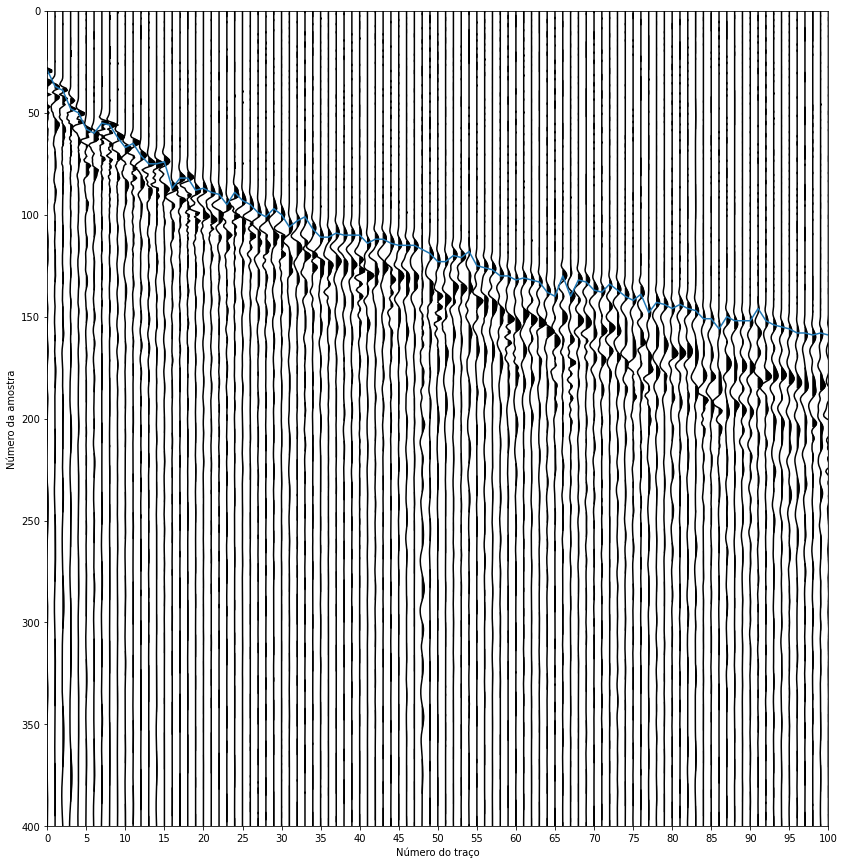

In [9]:
plotting_functions.wigle_plot(X[X.N_tiro==268][np.arange(0,1001)].values,0,
                              X[X.N_tiro==268][np.arange(0,1001)].shape[0],fat=15)
plt.plot(np.arange(0,len(picks['alig_268']))*15,picks['alig_268'])
plt.ylim(400,0)
plt.xlim(0,100*15)

## Plots - TCC

In [11]:
traces = np.asarray(X[X.N_tiro==268][np.arange(0,1001)].values)
traces

array([[-1.1921657e-07,  0.0000000e+00,  0.0000000e+00, ...,
         6.6037965e-06,  5.1406369e-06,  3.5483763e-06],
       [-2.3843313e-07,  0.0000000e+00,  1.1921657e-07, ...,
        -7.7518649e-07, -2.1088890e-06, -3.3621809e-06],
       [ 0.0000000e+00,  1.1921657e-07, -1.1921657e-07, ...,
        -1.6249076e-05, -1.7052400e-05, -1.7330152e-05],
       ...,
       [-1.8626494e-08, -2.0953095e-08,  5.6810123e-08, ...,
        -3.1573052e-07, -4.4890896e-07, -5.4250148e-07],
       [-1.7555584e-07, -9.7326961e-08, -4.0981945e-08, ...,
         3.0735112e-07,  7.0176310e-07,  9.6763870e-07],
       [ 7.7671893e-07, -9.0805884e-08, -8.6288134e-07, ...,
        -5.5644938e-07,  3.7113341e-07,  5.4667134e-07]], dtype=float32)

In [12]:
labels = np.asarray(picks['alig_268'])
labels

array([ 29,  37,  39,  48,  50,  58,  60,  55,  56,  62,  67,  65,  71,
        75,  75,  74,  87,  82,  82,  88,  87,  89,  90,  95,  89,  93,
        95,  99, 101,  97, 100, 106, 103, 101, 107, 111, 111, 109, 110,
       110, 110, 114, 112, 112, 114, 115, 115, 115, 117, 119, 123, 123,
       120, 121, 118, 125, 126, 127, 130, 130, 132, 131, 132, 133, 138,
       140, 130, 140, 132, 133, 137, 138, 134, 137, 140, 142, 139, 148,
       143, 144, 146, 144, 146, 147, 151, 151, 156, 150, 152, 152, 152,
       146, 152, 154, 155, 156, 158, 158, 159, 158, 159, 157, 163, 161,
       160, 161, 162, 163, 164, 169, 168, 169, 168, 169, 172, 170, 175,
       172, 179, 171, 178, 178, 176, 174, 176, 178, 181, 175, 174, 177,
       177, 177, 181, 183, 179, 182, 185, 183, 182, 190, 187, 189, 186,
       189, 191, 195, 194, 193, 196, 189, 195, 196, 193, 196, 195, 201,
       199, 196, 199, 198, 199, 200, 199, 201, 201, 202, 202, 204, 201,
       198, 205, 203, 209, 205, 208, 209, 210, 209, 206, 208, 20

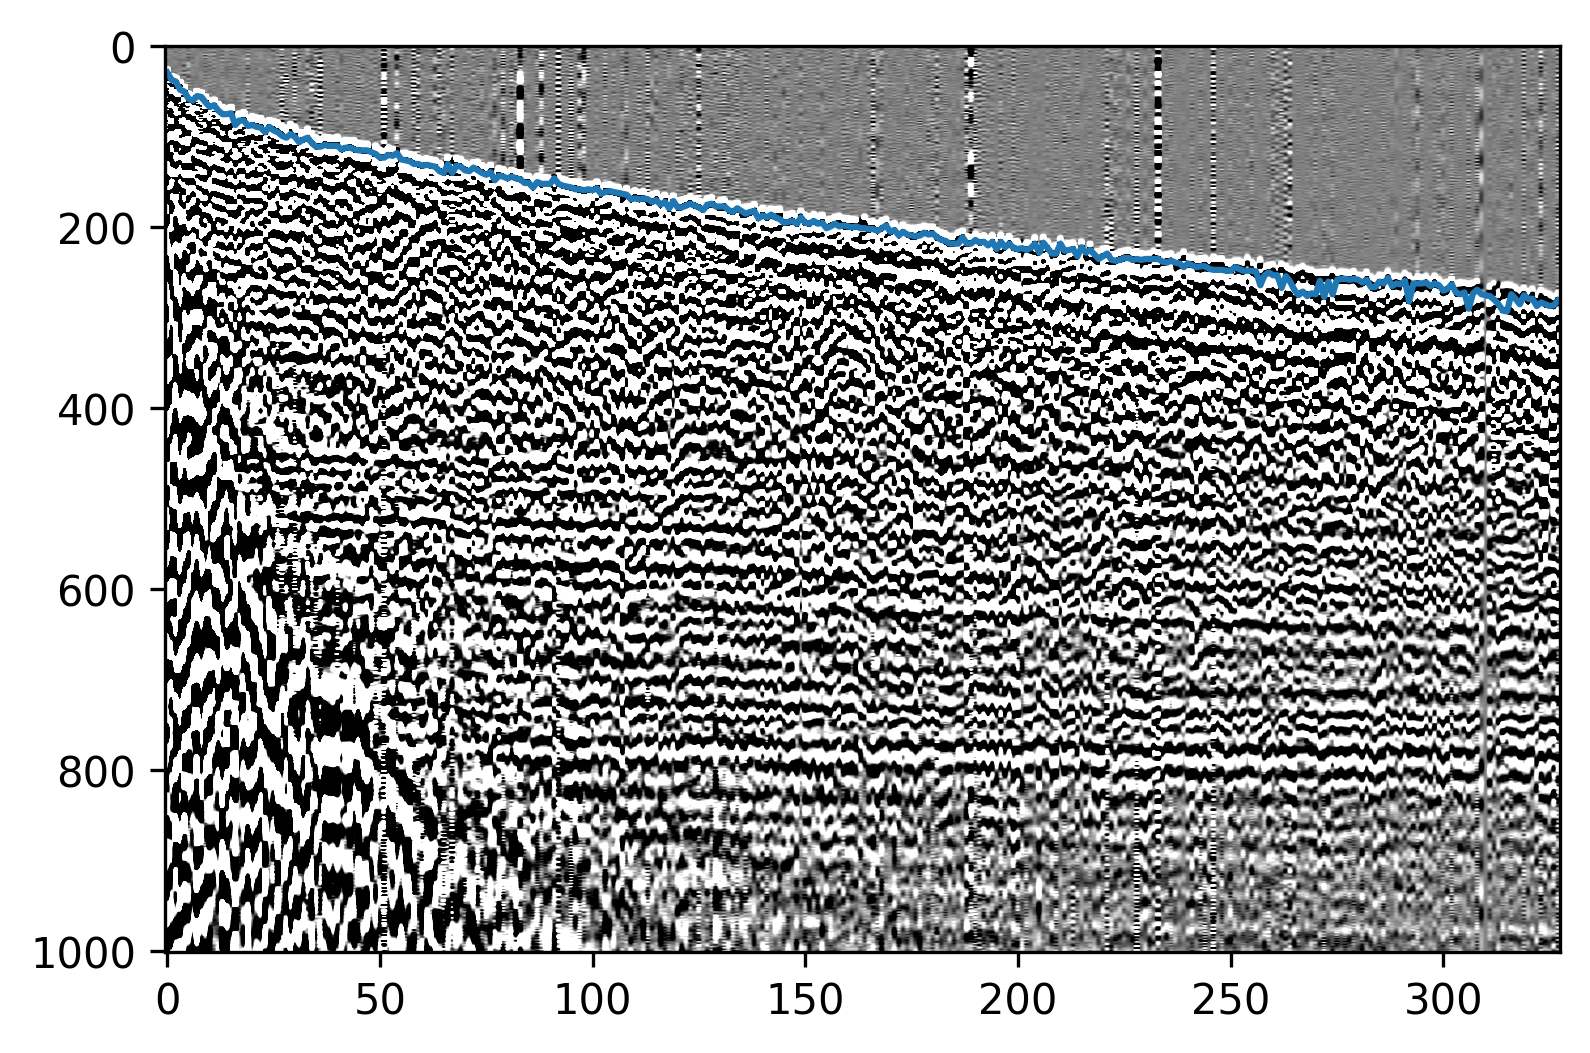

In [12]:
plt.figure(dpi=300)
plt.imshow(X[X.N_tiro==268][np.arange(0,1001)].values.T,
           cmap='gray_r',aspect='auto',vmin=-0.000001,vmax=0.000001)
plt.plot(np.arange(0,len(picks['alig_268'])),picks['alig_268'])

In [13]:
mask = np.zeros(shape=(len(picks['alig_268']),1001))
for i in range(mask.shape[0]):
    mask[i,np.arange(picks['alig_268'][i],1001)] = 1

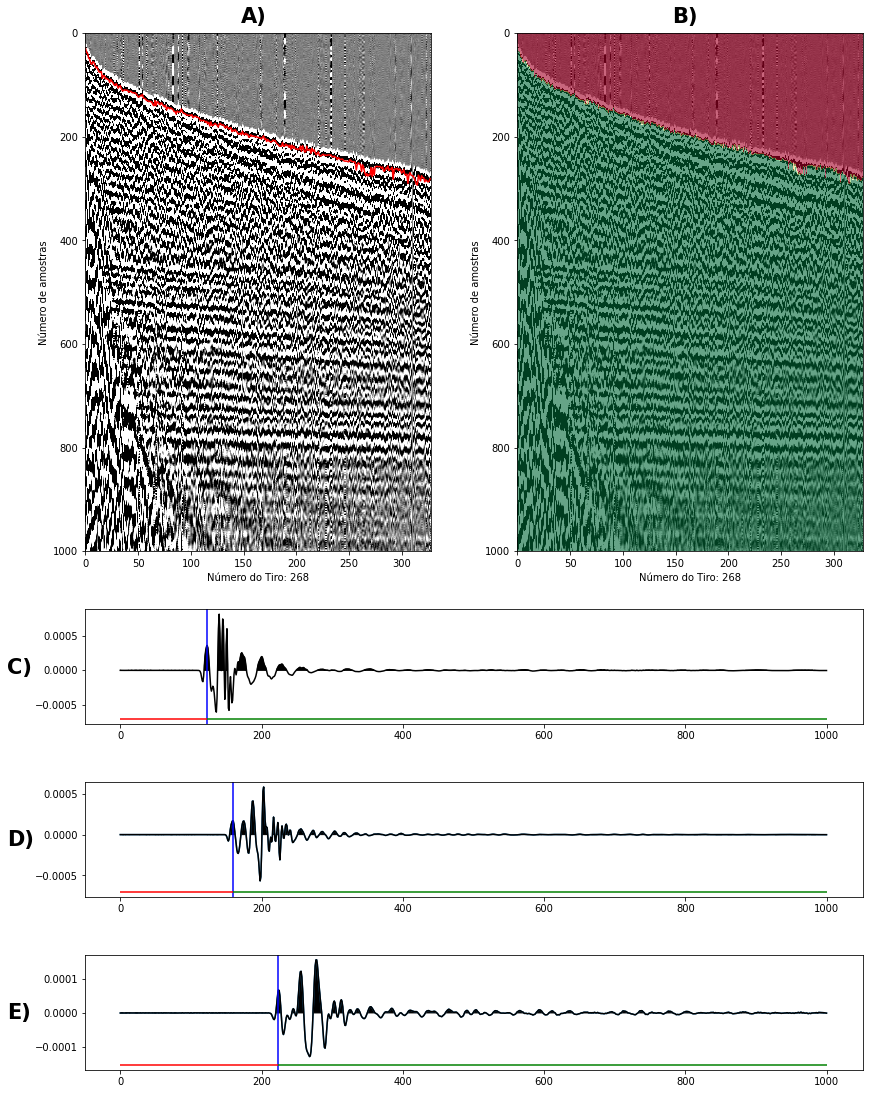

In [25]:
fig = plt.figure(figsize=(12,16))

axes = []

axes.append(fig.add_axes([0.05,0.5,0.4,0.45]))

axes.append(fig.add_axes([0.55,0.5,0.4,0.45]))

axes.append(fig.add_axes([0.05,0.35,0.9,0.1]))

axes.append(fig.add_axes([0.05,0.2,0.9,0.1]))

axes.append(fig.add_axes([0.05,0.05,0.9,0.1]))

#images
axes[0].imshow(traces.T,
           cmap='gray_r',aspect='auto',vmin=-0.000001,vmax=0.000001)
axes[0].plot(np.arange(0,len(picks['alig_268'])),picks['alig_268'], color='red')
axes[0].set_xlabel('Número do Tiro: 268', fontsize=10)
axes[0].set_ylabel('Número de amostras', fontsize=10)

axes[1].imshow(traces.T,
           cmap='gray_r',aspect='auto',vmin=-0.000001,vmax=0.000001)
axes[1].imshow(mask.T,alpha=0.6,aspect='auto',cmap='RdYlGn') #winter, plasma, bwr,seismic, 
axes[1].set_xlabel('Número do Tiro: 268', fontsize=10)
axes[1].set_ylabel('Número de amostras', fontsize=10)


#traces
x = np.arange(0,len(traces[50]))
axes[2].plot(traces[50], color='black')
axes[2].fill_between(x=x,y1=traces[50],where=(traces[50]>0.0),color='black')
axes[2].axvline(x=labels[50], color='blue')
axes[2].hlines(y=-0.0007,xmin=0, xmax=labels[50], colors='red')
axes[2].hlines(y=-0.0007, xmin=labels[50], xmax = traces.shape[1], colors='green')

axes[3].plot(traces[100])
axes[3].plot(traces[100], color='black')
axes[3].fill_between(x=x,y1=traces[100],where=(traces[100]>0.0),color='black')
axes[3].axvline(x=labels[100], color='blue')
axes[3].hlines(y=-0.0007,xmin=0, xmax=labels[100], colors='red')
axes[3].hlines(y=-0.0007, xmin=labels[100], xmax = traces.shape[1], colors='green')

axes[4].plot(traces[200])
axes[4].plot(traces[200], color='black')
axes[4].fill_between(x=x,y1=traces[200],where=(traces[200]>0.0),color='black')
axes[4].axvline(x=labels[200], color='blue')
axes[4].hlines(y=-0.00015,xmin=0, xmax=labels[200], colors='red')
axes[4].hlines(y=-0.00015, xmin=labels[200], xmax = traces.shape[1], colors='green')

rotulos_linha_1 = ['A)', 'B)']
rotulos_linha_2 = ['C)', 'D)', 'E)']
for i, ax in enumerate(axes[:2]):
    ax.text(0.45, 1.05, rotulos_linha_1[i], 
            transform=ax.transAxes, fontsize=21, fontweight='bold', va='top', ha='left')
    
for i, ax in enumerate(axes[2:]):
    ax.text(-0.10, 0.58, rotulos_linha_2[i], 
            transform=ax.transAxes, fontsize=21, fontweight='bold', va='top', ha='left')    



# plt.savefig('dataset_exemplo.jpg',bbox_inches='tight', pad_inches=0.8)

Text(-0.1, 0.58, 'B)')

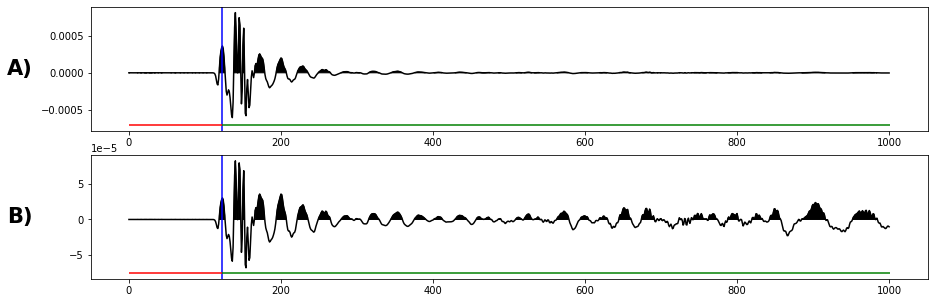

In [54]:
v_min,v_max= 1700,6000
t_min,t_max, t0 = 0.004, 4.004, 2
t = np.arange(0.004,1001*0.004,0.004)
alpha = (v_max-v_min)/(t_max-t_min)
v = alpha*t+v_min
# traces = dataset[dataset.columns[:1001]]
traces_arr = np.asarray(traces[50])
traces_gain = traces_arr*((v**2)*t)/((v[np.where(t==t0)]**2)*t0).T

x = np.arange(0,len(traces[50]))
plt.figure(figsize=(15,5))
plt.subplot(2, 1, 1)
plt.plot(traces[50], color='black')
plt.fill_between(x=x,y1=traces[50],where=(traces[50]>0.0),color='black')
plt.axvline(x=labels[50], color='blue')
plt.hlines(y=-0.0007,xmin=0, xmax=labels[50], colors='red')
plt.hlines(y=-0.0007, xmin=labels[50], xmax = traces.shape[1], colors='green')
plt.text(-0.10, 0.58, 'A)', transform=plt.gca().transAxes, fontsize=21,
         fontweight='bold', va='top', ha='left')

# plt.savefig('trace_example.jpeg')


# plt.figure(figsize=(15,3))
plt.subplot(2, 1, 2)
plt.plot(traces_gain, color='black')
plt.fill_between(x=x,y1=traces_gain,where=(traces_gain>0.0),color='black')
plt.axvline(x=labels[50], color='blue')
plt.hlines(y=-0.000075,xmin=0, xmax=labels[50], colors='red')
plt.hlines(y=-0.000075, xmin=labels[50], xmax = traces.shape[1], colors='green')
plt.text(-0.10, 0.58, 'B)', transform=plt.gca().transAxes, fontsize=21,
         fontweight='bold', va='top', ha='left')

# plt.savefig('traces_with_without_gain.jpeg')

## Continuação do Training_Data_Process

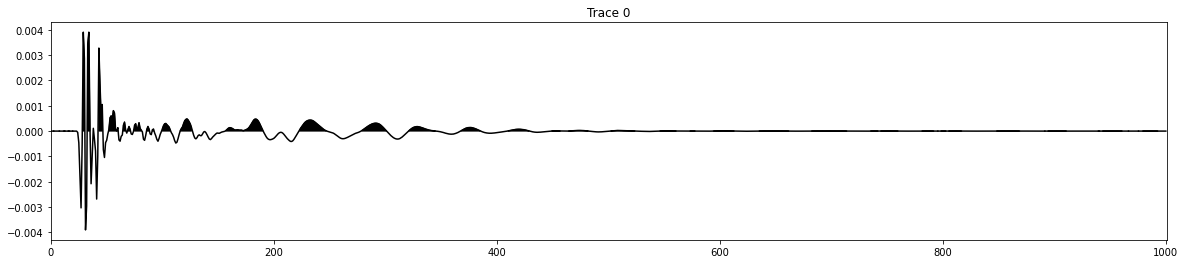

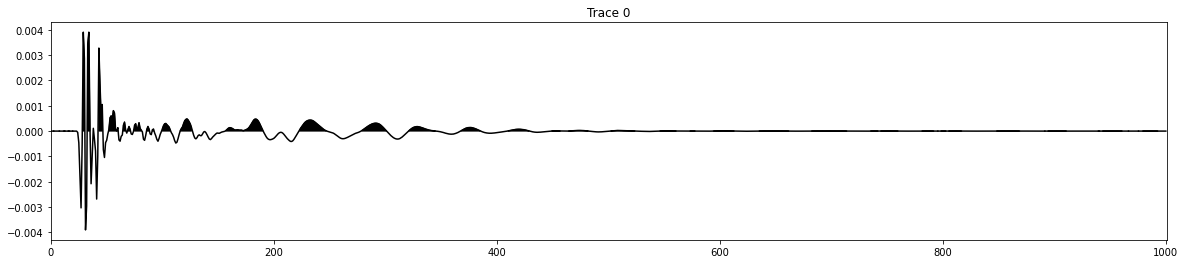

In [119]:
#plot do traço separado
plotting_functions.plot_single_trace_fig(np.asarray(X[np.arange(0,1001)]),0)

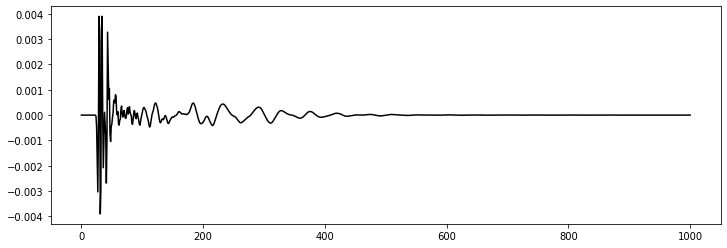

In [142]:
#plotting do traço separado para teste

# t = np.asarray(X[np.arange(0,1001)])
# x = np.arange(0,len(t[0]))

# # print(x)
# # print('')
# # print(t)
# # print('')
# # print(t[0])

# plt.figure(figsize=(12,4))
# plt.plot(x,t[0],color='black')
# plt.fill_between(x=x,y1=t[0],where=(t[0]>0.0),color='black')

In [25]:
n_trace = []
for i in picks.keys():
    n_trace.append(int(i.split('_')[-1]))
print(n_trace)

[18, 18, 18, 39, 39, 39, 59, 59, 59, 80, 80, 80, 100, 100, 100, 120, 120, 120, 140, 140, 140, 161, 161, 161, 183, 183, 183, 203, 203, 203, 223, 223, 223, 243, 243, 268, 268, 268, 288, 288, 288, 309, 309, 309, 329, 329, 329, 351, 351, 351, 371, 371, 371, 39, 39, 39, 18, 18, 18, 59, 59, 59, 80, 80, 80, 100, 100, 100, 120, 120, 120, 140, 140, 140, 161, 161, 161, 183, 183, 183, 203, 203, 203, 223, 223, 223, 268, 268, 268, 288, 288, 288, 309, 309, 309, 329, 329, 329, 351, 351, 351, 371, 371, 371]


In [26]:
#Removendo pick 243 por falta de dado(alig_243)
n_trace.remove(243)
n_trace.remove(243)

In [27]:
valores = np.unique(n_trace)
print(valores)
print(type(valores))

[ 18  39  59  80 100 120 140 161 183 203 223 268 288 309 329 351 371]
<class 'numpy.ndarray'>


In [28]:
dataset = X[X.N_tiro.isin(valores)]

In [25]:
# dataset.to_csv(join(directory,'dataset_train.csv'), index=False)

In [29]:
#Criando uma coluna preenchida por NaN
dataset['n_picks']= np.nan 

In [30]:
for i in valores:
    dataset['n_picks'].loc[dataset[dataset.N_tiro==i].index]

In [31]:
for i in valores:
    try:
        dataset['n_picks'].loc[dataset[dataset.N_tiro==i].index] = picks[f'alig_{i}'][:len(dataset.loc[dataset[dataset.N_tiro==i].index]['n_picks'])]
    except:
        dataset['n_picks'].loc[dataset[dataset.N_tiro==i].index][:len(picks[f'alig_{i}'])] = picks[f'alig_{i}']
    print(i)

18
39
59
80
100
120
140
161
183
203
223
268
288
309
329
351
371


In [32]:
dataset = dataset.dropna()
dataset

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,1000,N_tiro,n_picks
0,-4.768662e-07,-5.960828e-07,1.192166e-07,5.960828e-07,-1.192166e-07,-7.152993e-07,-1.192166e-07,5.960828e-07,4.768662e-07,-2.384331e-07,...,5.029126e-08,-8.708855e-08,-2.696396e-07,-6.005286e-08,-5.988536e-07,-5.522947e-07,8.847627e-08,-4.261002e-07,18,29.0
1,2.375194e-07,-1.187597e-07,2.375194e-07,4.750387e-07,0.000000e+00,2.375194e-07,1.187597e-07,2.375194e-07,3.562791e-07,-2.375194e-07,...,-4.940434e-07,2.421344e-07,-3.255137e-07,-5.401612e-07,-6.146843e-08,-9.781155e-08,-1.941798e-07,-2.863816e-07,18,38.0
2,4.768662e-07,1.430599e-06,4.768662e-07,1.192166e-07,2.503548e-06,4.291796e-06,4.291796e-06,4.768663e-06,6.318477e-06,8.464375e-06,...,2.720513e-06,2.068888e-07,3.073508e-06,7.229784e-06,8.485464e-06,4.380154e-06,1.544116e-07,-1.021940e-08,18,39.0
3,8.372444e-08,8.372444e-08,8.372444e-08,0.000000e+00,-8.372444e-08,0.000000e+00,0.000000e+00,-8.372444e-08,-8.372444e-08,-8.372444e-08,...,3.492270e-07,2.980033e-07,2.300441e-07,2.649483e-07,1.932444e-07,1.173336e-07,1.588025e-07,6.425353e-08,18,47.0
4,-2.102857e-07,2.102857e-07,-1.051429e-07,-3.154286e-07,-2.102857e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.102857e-07,...,-7.452763e-08,4.018773e-07,1.075786e-07,-9.639439e-08,1.573807e-07,2.067313e-07,2.873275e-07,2.160618e-07,18,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100362,-1.108278e-07,4.150396e-08,-3.112500e-08,-9.102098e-08,-4.904744e-08,-4.713929e-09,2.358153e-08,-9.055140e-08,-2.782585e-08,8.017241e-08,...,-2.334501e-07,-1.471442e-07,-1.132434e-08,-7.546350e-08,7.687299e-08,1.839242e-07,-1.132434e-08,-3.206918e-08,371,277.0
100363,-6.613142e-09,-1.896927e-07,-2.085750e-07,1.000238e-07,1.696793e-08,-2.807540e-07,-1.113792e-07,1.646760e-07,1.057232e-07,-1.991339e-07,...,-1.146761e-07,-7.077290e-08,-6.794937e-08,-3.496755e-07,-2.246079e-07,-7.975257e-08,-3.284297e-07,-3.581617e-07,371,273.0
100364,-1.794730e-08,-6.138752e-09,-3.305264e-09,-1.039039e-08,7.556906e-09,4.628217e-08,3.872526e-08,9.435541e-10,2.502961e-08,1.322388e-08,...,-1.922145e-07,-2.550261e-07,-1.775687e-07,-1.171277e-07,-1.057878e-07,-7.415144e-08,-1.114514e-07,-8.689830e-08,371,275.0
100365,-9.485170e-10,5.313568e-08,6.736343e-08,5.598122e-08,5.645548e-08,3.273632e-08,-3.319810e-09,9.959429e-09,8.586574e-08,5.455845e-08,...,9.393705e-08,1.015179e-07,1.679387e-07,9.772180e-08,-5.123631e-08,-1.029500e-07,2.277675e-08,1.608245e-07,371,276.0


# Shift

In [33]:
dataset_shifted = shift_function.shift(dataset)

In [34]:
dataset_shifted

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,1000,N_tiro,n_picks
0,-4.768662e-07,-5.960828e-07,1.192166e-07,5.960828e-07,-1.192166e-07,-7.152993e-07,-1.192166e-07,5.960828e-07,4.768662e-07,-2.384331e-07,...,5.029126e-08,-8.708855e-08,-2.696396e-07,-6.005286e-08,-5.988536e-07,-5.522947e-07,8.847627e-08,-4.261002e-07,18.0,29.0
1,2.375194e-07,-1.187597e-07,2.375194e-07,4.750387e-07,0.000000e+00,2.375194e-07,1.187597e-07,2.375194e-07,3.562791e-07,-2.375194e-07,...,-4.940434e-07,2.421344e-07,-3.255137e-07,-5.401612e-07,-6.146843e-08,-9.781155e-08,-1.941798e-07,-2.863816e-07,18.0,38.0
2,4.768662e-07,1.430599e-06,4.768662e-07,1.192166e-07,2.503548e-06,4.291796e-06,4.291796e-06,4.768663e-06,6.318477e-06,8.464375e-06,...,2.720513e-06,2.068888e-07,3.073508e-06,7.229784e-06,8.485464e-06,4.380154e-06,1.544116e-07,-1.021940e-08,18.0,39.0
3,8.372444e-08,8.372444e-08,8.372444e-08,0.000000e+00,-8.372444e-08,0.000000e+00,0.000000e+00,-8.372444e-08,-8.372444e-08,-8.372444e-08,...,3.492270e-07,2.980033e-07,2.300441e-07,2.649483e-07,1.932444e-07,1.173336e-07,1.588025e-07,6.425353e-08,18.0,47.0
4,-2.102857e-07,2.102857e-07,-1.051429e-07,-3.154286e-07,-2.102857e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.102857e-07,...,-7.452763e-08,4.018773e-07,1.075786e-07,-9.639439e-08,1.573807e-07,2.067313e-07,2.873275e-07,2.160618e-07,18.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19555,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.502401e-06,9.233634e-06,1.010054e-05,1.089334e-05,1.139846e-05,1.137480e-05,1.125444e-05,1.138350e-05,59.0,404.0
19556,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.524627e-06,3.946612e-07,-7.253830e-07,-1.716666e-06,-2.507973e-06,-3.060719e-06,-3.298177e-06,-3.226742e-06,351.0,514.0
19557,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.474467e-06,-2.194723e-06,-2.689234e-06,-2.778439e-06,-2.598447e-06,-2.397304e-06,-2.261771e-06,-2.001495e-06,161.0,561.0
19558,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,6.407851e-07,7.492786e-07,2.226231e-07,3.106078e-07,7.576544e-07,3.464592e-07,2.081417e-07,5.615676e-07,309.0,349.0


In [35]:
teste = np.asarray(dataset_shifted[dataset_shifted.columns[:1001]]) #corrige o gráfico
teste

array([[-4.7686621e-07, -5.9608277e-07,  1.1921657e-07, ...,
        -5.5229469e-07,  8.8476270e-08, -4.2610020e-07],
       [ 2.3751937e-07, -1.1875966e-07,  2.3751937e-07, ...,
        -9.7811551e-08, -1.9417985e-07, -2.8638163e-07],
       [ 4.7686621e-07,  1.4305988e-06,  4.7686621e-07, ...,
         4.3801538e-06,  1.5441157e-07, -1.0219395e-08],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.3973043e-06, -2.2617714e-06, -2.0014950e-06],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.4645916e-07,  2.0814167e-07,  5.6156756e-07],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.3004668e-07, -2.4868348e-07, -7.0777941e-07]], dtype=float32)

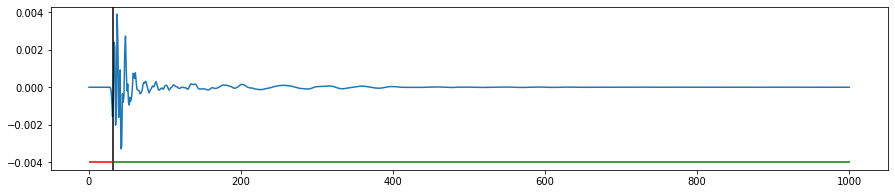

In [37]:
plt.figure(figsize=(15,3))
plt.plot(teste[1])
plt.axvline(x=32, color='black')
plt.hlines(y=-0.004,xmin=0, xmax=32, colors='red')
plt.hlines(y=-0.004, xmin=32, xmax = teste.shape[1], colors='green')
plt.show()

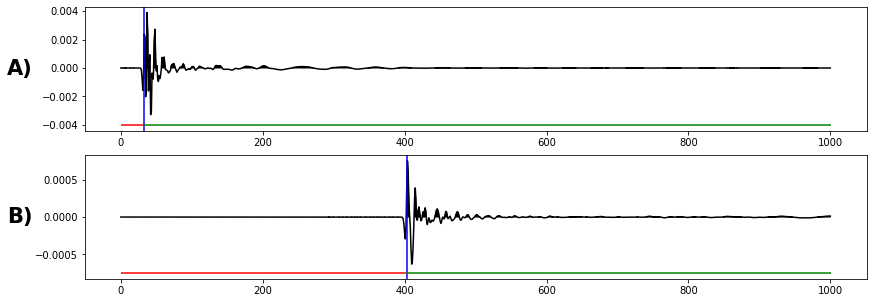

In [69]:
x = np.arange(0,len(teste[19555]))

plt.figure(figsize=(14,5))
plt.subplot(2, 1, 1)
plt.plot(teste[1], color='black')
plt.axvline(x=32, color='blue')
plt.fill_between(x=x,y1=teste[1],where=(teste[1]>0.0),color='black')
plt.hlines(y=-0.004,xmin=0, xmax=32, colors='red')
plt.hlines(y=-0.004, xmin=32, xmax = teste.shape[1], colors='green')
plt.text(-0.10, 0.58, 'A)', transform=plt.gca().transAxes, fontsize=21,
         fontweight='bold', va='top', ha='left')
# plt.show()

plt.subplot(2,1,2)
plt.plot(teste[19555], color='black')
plt.fill_between(x=x,y1=teste[19555],where=(teste[19555]>0.0),color='black')
plt.axvline(x=404, color='blue')
plt.hlines(y=-0.00075,xmin=0, xmax=400, colors='red')
plt.hlines(y=-0.00075, xmin=400, xmax = teste.shape[1], colors='green')
plt.text(-0.10, 0.58, 'B)', transform=plt.gca().transAxes, fontsize=21,
         fontweight='bold', va='top', ha='left')
# plt.savefig('trace_shifted_example.png')
# plt.show()

# Gain Applications

## Spherical Divergence

Formato de X (19560, 1001)
Formato de y (19560, 1001)
Total de traços: 19560
Total de rótulos: 19560
Inputs Shape: (19560, 1001)
Labels Shape: (19560, 1001)
Your data is now saved in:D:/Dados_TCC/Dados_treino\dataset_train.npz


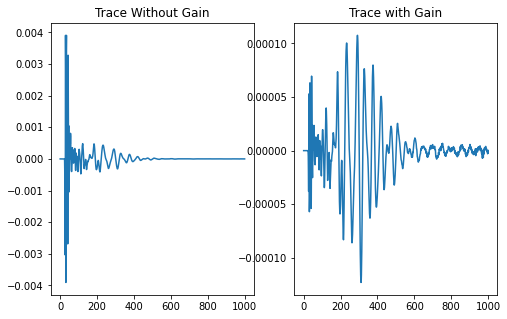

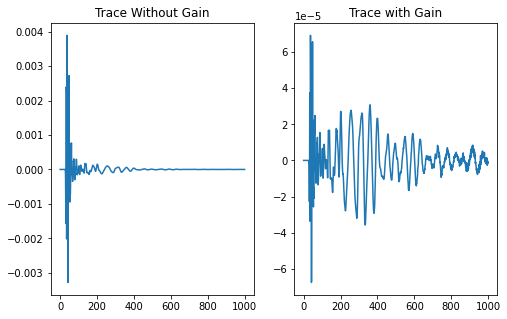

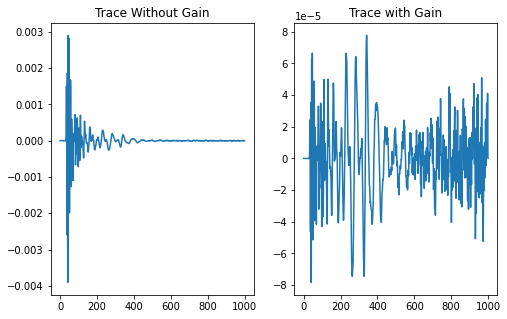

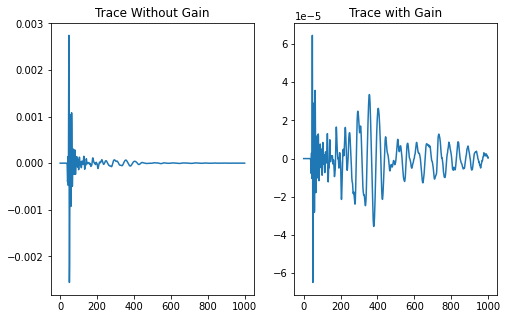

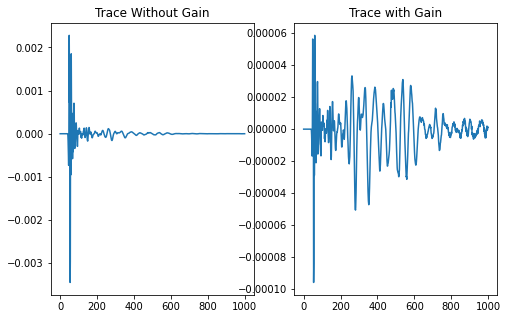

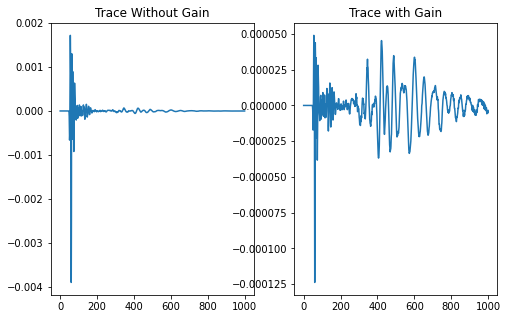

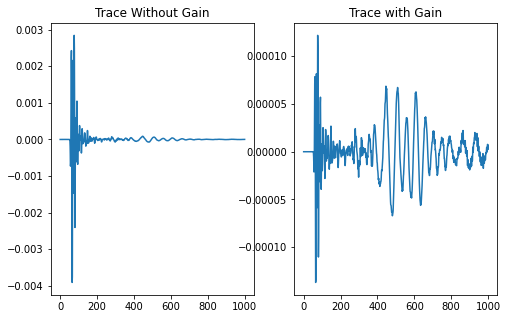

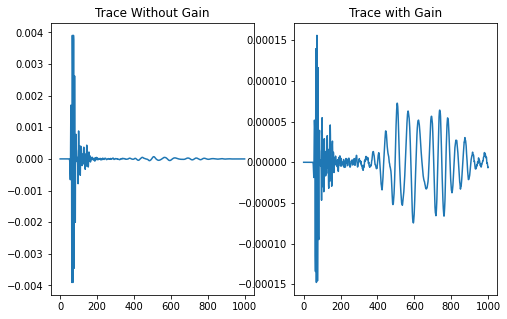

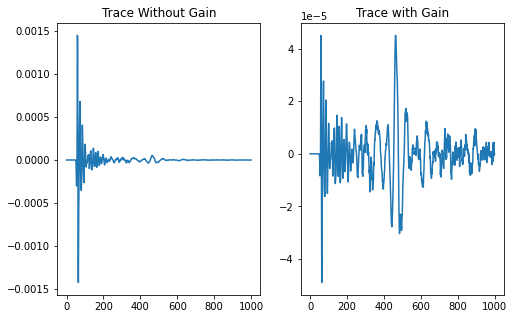

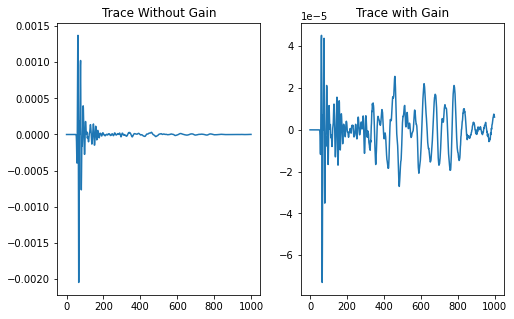

In [28]:
traces_gain = gain_functions.spherical_divergence(dataset_shifted,directory,plotting=True)

## AGC

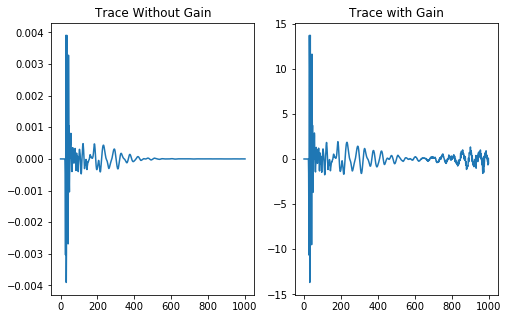

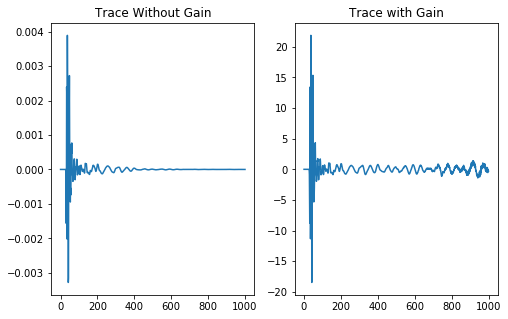

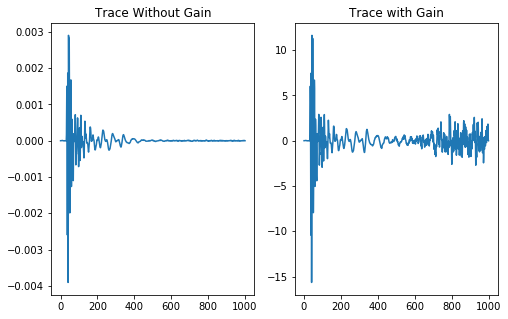

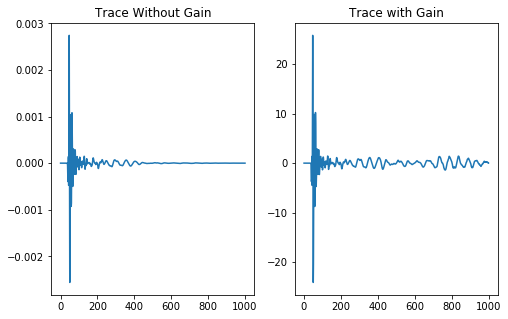

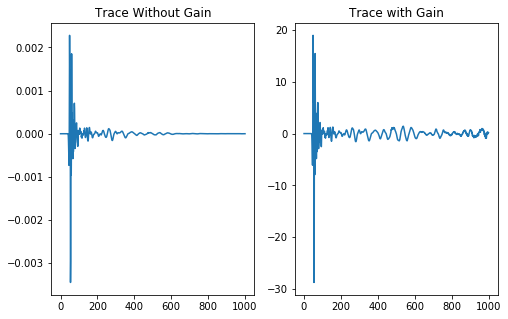

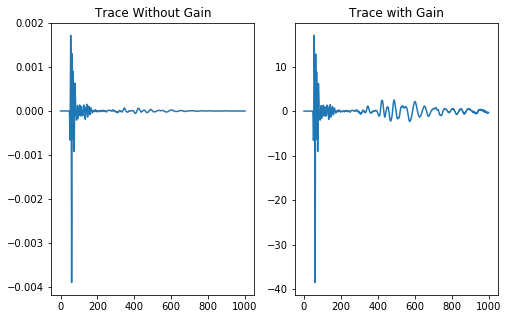

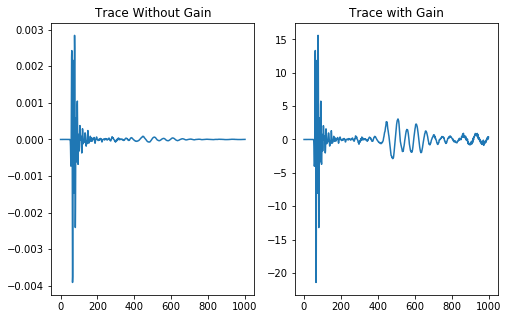

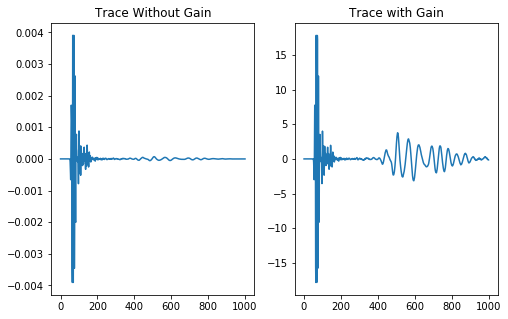

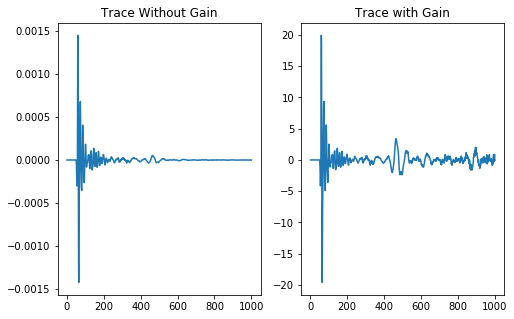

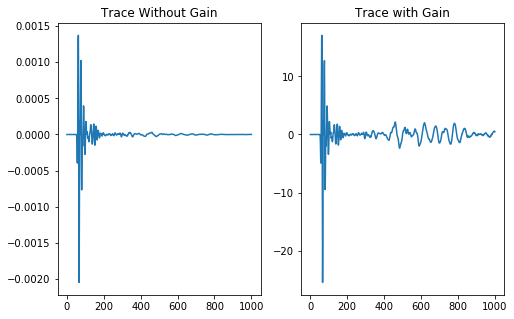

In [194]:
# traces_gain = gain_functions.gain_agc(datasetset_shifted,directory,plotting=False)

# Saving CSV

In [38]:
# dataset_shifted.to_csv(join(directory,'dataset.csv'), index=False)

# Checking the Dataset

In [93]:
#Carregando o dataset
traces_arr = np.load(join(directory,'dataset_train.npz'))['arr_0']
labels_arr = np.load(join(directory,'dataset_train.npz'))['arr_1']

print(traces_arr.shape)
print(labels_arr.shape)

(4890, 1001)
(4890, 1001)


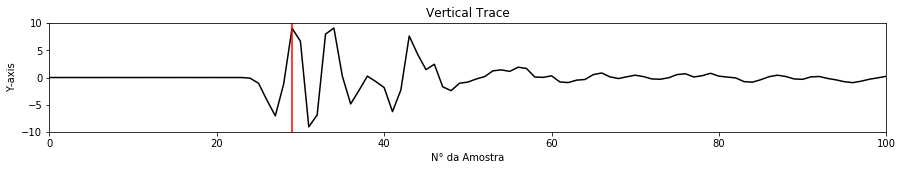

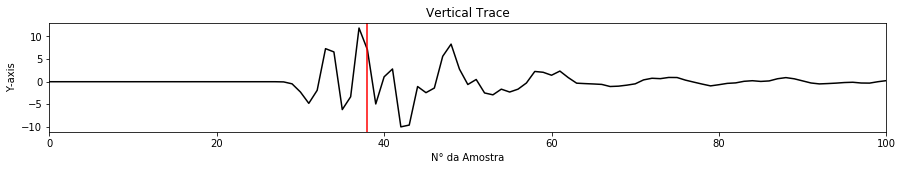

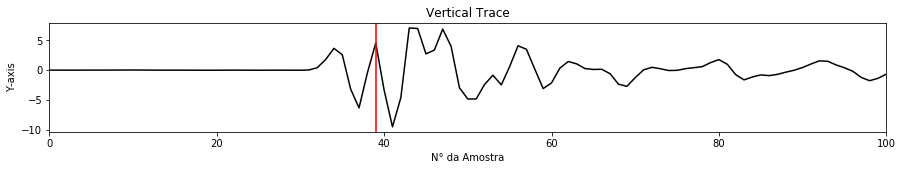

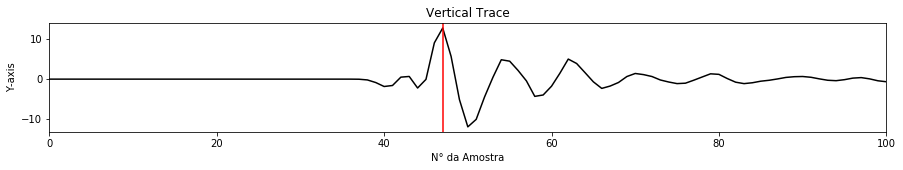

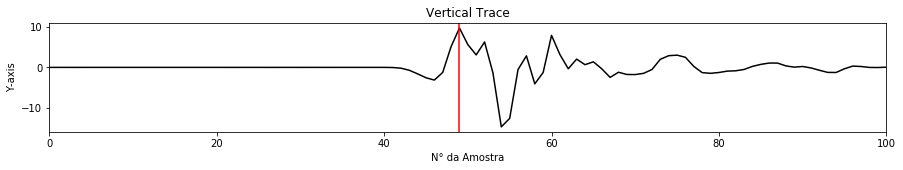

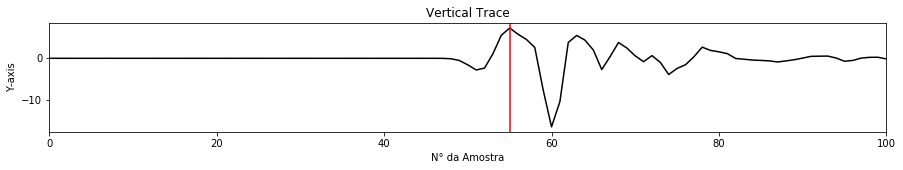

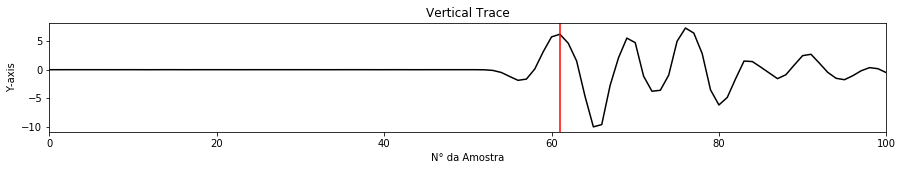

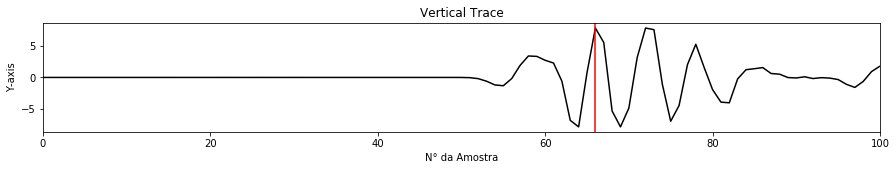

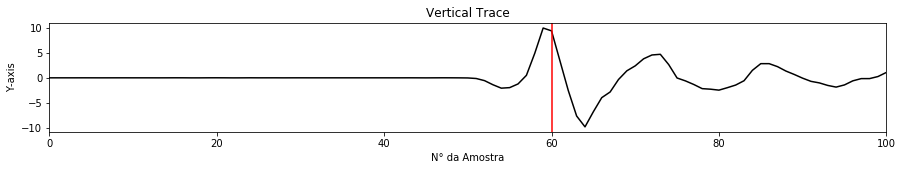

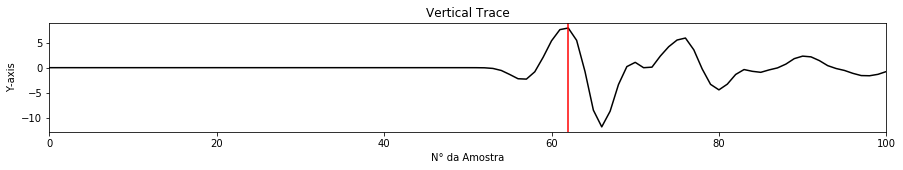

In [76]:
for i in range(0,10):#80000,80015
    fig,ax = plt.subplots(figsize=(15,2))
    ax.plot(traces_arr[i], color='black')
    ax.axvline(x=np.argmax(labels_arr[i]), color='red')
    ax.set_xlim([0,100])
    ax.set_xlabel('N° da Amostra')
    ax.set_ylabel('Y-axis')
    ax.set_title('Vertical Trace')
    
    plt.show()